In [1]:
#路径管理/全局变量
import os
import sys

# 设置为项目根目录（包含 data, pipline 等文件夹的目录）
project_root = os.path.abspath("..")
os.chdir(project_root)
sys.path.append(project_root)
from utils.config import KEYWORDS
from utils.path_helper import get_data_path

#基础模块
import numpy as np
import pandas as pd

#清洗函数，特征工程函数导入
from pipline.pipline import pipeline_house_data
from features_wlh.features_wlh import add_selected_features

#导入训练函数
from model.train_model import train_model
#选择训练函数，自己去调整
from sklearn.ensemble import RandomForestRegressor
#训练集划分(已经在train_model里面做过,导入只是告诉你已经做完了)
from sklearn.model_selection import train_test_split
#特征值相关性检验,共线性检验
from features_wlh.feature_analysis import plot_feature_correlation
from features_wlh.feature_vif_validation import check_multicollinearity
#评估
from model.evaluate import evaluate_model

In [2]:
# 读取数据
df = pd.read_csv(get_data_path("house_prices.csv"))
# 清洗数据
df_cleaned = pipeline_house_data(df, keywords=KEYWORDS)

Fundenmental Analysis

Analysis with picture and Visualization

Project  of Features and Validation

In [4]:
My_features = ["Furnishing_giving","floor_level_normalize","has_amenities",
"has_green_space","has_proximity","is_affordable","is_basement","is_deal","is_gated",
"is_ground","is_luxury","is_marketing_strong","is_new","is_prime_location","is_resale",
"is_spacious","is_well_planned","location_rank",
"normal_Carpet_Area",
"ownership_score"] #一个示例，训练的时候根据特征分析自己去选

df_cleaned_features = add_selected_features(df_cleaned, features_to_use = My_features)

c:\Users\K.Hawk\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


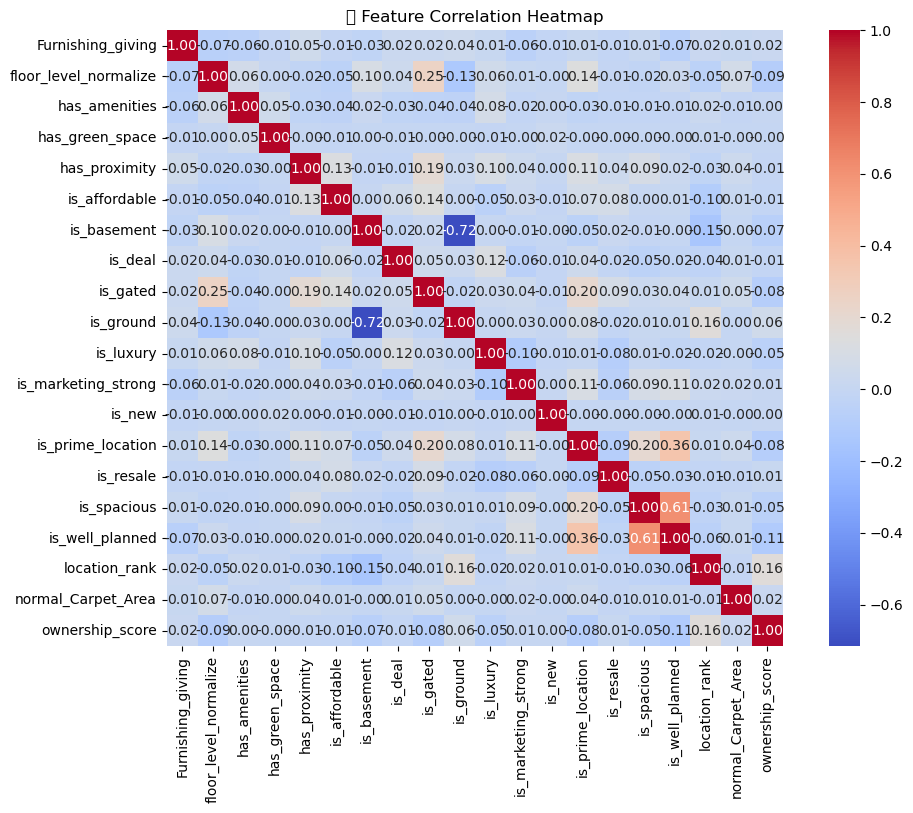

✅ 没有检测到高度相关的特征对。


c:\Users\K.Hawk\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


🧪 方差膨胀因子（VIF）检测结果：
                  feature           VIF
0                   const  9.007199e+15
3             Carpet Area           inf
17       location_encoded  3.336273e+01
19              max_floor  3.002400e+15
31  floor_level_normalize           inf
32          location_rank  5.201703e+01
33         location_level  3.444260e+01
34     normal_Carpet_Area           inf


In [5]:
plot_feature_correlation(df_cleaned_features, features = My_features, threshold=0.85)
vif_result = check_multicollinearity(df_cleaned_features, threshold=5)

Train Model (去train_model.py里面调整参数,调整模型选择，notebook仅用于使用grid找参数)

In [6]:
after_trained_model, X_test, y_test = train_model(df_cleaned_features, df_cleaned, features_to_use = My_features) 

✅ 模型训练完成，保存到： models_saved/rf_model.pkl


Evaulate Model & Parameter optimization

In [7]:
evaluate_model(after_trained_model, X_test, y_test)



MAE: 1812528.37
RMSE: 75696493.78
R² Score: 0.0187


{'MAE': 1812528.3714058434,
 'RMSE': 75696493.77942784,
 'R2': 0.01872977690634181}